In [1]:
import matplotlib as mpl
from utils import plot
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf
import time
from ig_attack import IntegratedGradientsAttack
from utils import dataReader, get_session, integrated_gradients, softmax
from model import Model

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
X, y = dataReader()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Image ID: 50, Image Label : 6


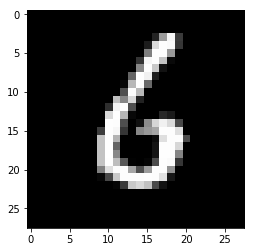

In [3]:
n = 50
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image ID: {}, Image Label : {}".format(n, y[n]))
%matplotlib inline
plt.imshow(X[n,:,:,0], cmap='gray')

In [4]:
tf.reset_default_graph()
sess = get_session()
model = Model(create_saliency_op = 'ig')

model_dir = 'models/nat_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

In [5]:
k_top = 200 #Recommended for ImageNet
eval_k_top = 100
num_steps = 100 #Number of steps in Integrated Gradients Algorithm (refer to the original paper)
attack_method = 'topK'
epsilon = 0.3 #Maximum allowed perturbation for each pixel
attack_steps = 300
attack_times = 1
alpha = 0.01
attack_measure = "kendall"
reference_image = np.zeros((28,28,1)) #Our chosen reference(the mean image)

module = IntegratedGradientsAttack(sess = sess, test_image = test_image, 
                                   original_label = original_label, NET = model,
                                   attack_method = attack_method, epsilon = epsilon,
                                   k_top = k_top, eval_k_top = eval_k_top, num_steps = num_steps,
                                   attack_iters = attack_steps,
                                   attack_times = attack_times,
                                   alpha = alpha,  
                                   attack_measure = attack_measure,
                                   reference_image = reference_image, 
                                   same_label = True)

In [6]:
output = module.iterative_attack_once()

print('''For maximum allowed perturbation size equal to {}, the resulting perturbation size was equal to {}'''.format(epsilon, np.max(np.abs(test_image - module.perturbed_image))))

print('''{} % of the {} most salient pixels in the original image are among {} most salient pixels of the 
perturbed image'''.format(output[0]*100,eval_k_top,eval_k_top))

print("The Spearman rank correlation between salieny maps is equal to {}".format(output[1]))

print("The kendall rank correlation between salieny maps is equal to {}".format(output[2]))

For maximum allowed perturbation size equal to 0.3, the resulting perturbation size was equal to 0.30000001192092896
37.0 % of the 100 most salient pixels in the original image are among 100 most salient pixels of the 
perturbed image
The Spearman rank correlation between salieny maps is equal to 0.07704312479821057
The kendall rank correlation between salieny maps is equal to 0.05673909077947812


In [7]:
nat_output = sess.run(model.output_with_relu, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)
adv_output = sess.run(model.output_with_relu, feed_dict={model.input: [module.perturbed_image]})
adv_pred = softmax(adv_output)
print('original prediction: {}, confidence: {}'.format(np.argmax(nat_pred), np.max(nat_pred)))
print('perturbed prediction: {}, confidence: {}'.format(np.argmax(adv_pred), np.max(adv_pred)))

original prediction: 6, confidence: 1.0
perturbed prediction: 6, confidence: 0.9988270401954651


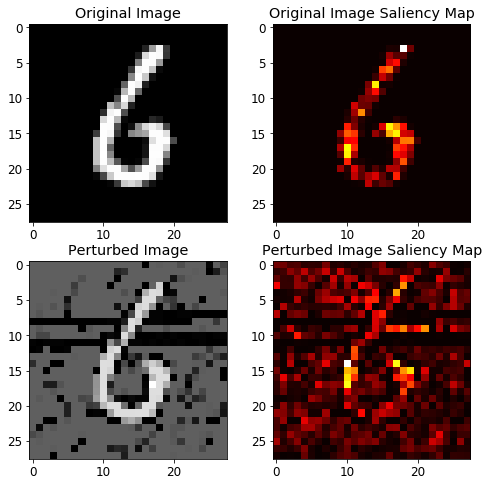

In [8]:
original_IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(original_IG),-1)
original_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(2,2,1)
plt.title("Original Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(2,2,2)
plt.title("Original Image Saliency Map")
plt.imshow(original_saliency, cmap="hot")
perturbed_IG = integrated_gradients(sess, reference_image, module.perturbed_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)
saliency = np.sum(np.abs(perturbed_IG),-1)
perturbed_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(2,2,3)
plt.title("Perturbed Image")
perturbed_image = (module.perturbed_image[:,:,0])
plt.imshow(perturbed_image, cmap='gray')
plt.subplot(2,2,4)
plt.title("Perturbed Image Saliency Map")
plt.imshow(perturbed_saliency, cmap="hot")